### Updated Sample: 99,999 Objects
- Chosen from the DR11 test brick region (ignoring the core of Coma). 
- The objects in this sample are "ostensibly small"
- Every galaxy name should be unique -- based on "central" coordinates of galaxy with a resolution of 3.6"

#### Columns:

- _INIT --> initial ellipse parameters (BX, BY are in pixels)
    - BA_INIT
    - PA_INIT
    - SMA_INIT
    - BX_INIT
    - BY_INIT
    - RA_INIT
    - DEC_INIT
- GROUP -->
    - GROUP_ID --> ID of group
    - GROUP_NAME --> name of group
    - GROUP_MULT --> number of objects in group
    - GROUP_PRIMARY --> object with the largest initial diameter
    - GROUP_RA --> RA of group center
    - GROUP_DEC --> DEC of group center
    - GROUP_DIAMETER --> Size of group (Mpc?)
- RA, DEC, BX, BY --> the 'final' values for the galaxy
- _MOMENT -->
    - SMA_MOMENT --> SMA of galaxy ellipse
    - BA_MOMENT --> BA (axis ratio) of galaxy ellipse
    - PA_MOMENT --> PA (position angle) of galaxy ellipse
- COG_MTOT_ --> total magnitude in [FUV NUV], [GRIZ], [W1-4]
- COG_MTOT_ERR_ --> errors for the above columns; now fixed.
- SMA50_ --> half-light SMA length in each bandpass based on the fit to the curve of growth
- FLUX_AP00, FLUX_P01, FLUX_AP02, FLUX_AP03, FLUX_AP04 --> flux measurements within each aperture (which is some multiple of SMA_MOMENT -- 0.5, 1.0, 1.25, 1.5, 2.0)

 ### Load modules and packages and libraries and tables and...

In [1]:
import numpy as np
from rich import print
from matplotlib import pyplot as plt
%matplotlib inline
from astropy.table import Table, Column
import pandas as pd
import seaborn as sns
from astropy.coordinates import SkyCoord
from astropy import units as u
from matplotlib import colors

import os
homedir=os.getenv("HOME")

In [2]:
#read in the .fits file. first is ellipse fitting, second is SExtractor.
ellipse_tab=Table.read(homedir+'/Desktop/wisesize/SGA2025_tables/SGA2025-ellipse-v0.3.fits',hdu=1)
tractor_tab=Table.read(homedir+'/Desktop/wisesize/SGA2025_tables/SGA2025-ellipse-v0.3.fits',hdu=2)
sga2020 = Table.read(homedir+'/Desktop/wisesize/SGA2025_tables/sga2020.csv')

### Match SGA2025 and SGA2020 catalogs
#### NUMBER OF MATCHES: 83505

In [368]:
#isolate RA, DEC, R26_R [2020], R26_R [2025], PA_MOMENT, BA_MOMENT
#sga2020 is defined under the "Load Modules..." section
sga2020_tab = Table({'RA': sga2020['ra'],
                     'DEC': sga2020['dec'],
                     'R26_R': sga2020['sma_sb26'],
                     'pa': sga2020['pa'],
                     'ba': sga2020['ba']})

sga2025_sga2020_tab = Table({'RA': ellipse_tab['RA'],
                     'DEC': ellipse_tab['DEC'],
                     'R26_R': ellipse_tab['R26_R'],
                     'PA_MOMENT': ellipse_tab['PA_MOMENT'],
                     'BA_MOMENT': ellipse_tab['BA_MOMENT'],
                     'SGAID': ellipse_tab['SGAID']})

In [369]:
#create SkyCoord objects for each catalog...
coords2020 = SkyCoord(ra=sga2020_tab['RA']*u.deg, dec=sga2020_tab['DEC']*u.deg, frame='icrs')
coords2025 = SkyCoord(ra=sga2025_sga2020_tab['RA']*u.deg, dec=sga2025_sga2020_tab['DEC']*u.deg, frame='icrs')

#match coordinates in sga2025 to the closest in sga2020
idx, dist_2d, dist_3d = coords2025.match_to_catalog_sky(coords2020)

#add matched information to sga2025
sga2025_sga2020_tab['sga2020_R26_R'] = sga2020_tab['R26_R'][idx]
sga2025_sga2020_tab['sga2020_PA_MOMENT'] = sga2020_tab['pa'][idx]
sga2025_sga2020_tab['sga2020_BA_MOMENT'] = sga2020_tab['ba'][idx]
sga2025_sga2020_tab['Separation'] = dist_2d

In [370]:
#I'll keep matches with a separation of 3.6", in honor of the resolution of SGA2025 names
sga_flag=(sga2025_sga2020_tab['Separation']<=3.6/3600.)

In [371]:
sga2025_sga2020_tab = sga2025_sga2020_tab[sga_flag]

In [372]:
print('Matches:', len(sga2025_sga2020_tab))

Matches: 83505

### Create empty table for error-handling
- A more streamline way to document failure modes 

In [339]:
failure_modes = Table({'SGAID':ellipse_tab['SGAID']})

### QA One
#### Separations between $\theta_{INIT}$, $\theta_{FINAL}$, and $\theta_{TRACTOR}$

#### Number of galaxies with no Tractor RA, DEC: 264

In [334]:
#ellipse_tab.columns --> RA_INIT, DEC_INIT, RA, DEC, RA_TRACTOR, DEC_TRACTOR

In [330]:
radec_init = ellipse_tab['RA_INIT'], ellipse_tab['DEC_INIT']
radec_final = ellipse_tab['RA'], ellipse_tab['DEC']
radec_tractor = ellipse_tab['RA_TRACTOR'], ellipse_tab['DEC_TRACTOR']

zero_flag = (radec_tractor[0]!=0) & (radec_tractor[1]!=0)

# Use your existing 'flag' to select objects
ra_init, dec_init = radec_init[0][zero_flag], radec_init[1][zero_flag]
ra_final, dec_final = radec_final[0][zero_flag], radec_final[1][zero_flag]
ra_tractor, dec_tractor = radec_tractor[0][zero_flag], radec_tractor[1][zero_flag]

delta_ra_init_final   = (ra_init - ra_final)*np.cos(dec_final)
delta_dec_init_final = (dec_init - dec_final)
delta_ra_final_tractor = (ra_final - ra_tractor)*np.cos(dec_tractor)
delta_dec_final_tractor = (dec_final - dec_tractor)
delta_ra_tractor_init = (ra_tractor - ra_init)*np.cos(dec_init)
delta_dec_tractor_init = (dec_tractor - dec_init)

In [331]:
import warnings
warnings.filterwarnings("ignore")

df= pd.DataFrame({r'$\Delta$RA [INIT-FINAL]':delta_ra_init_final,
                  r'$\Delta$DEC [INIT-FINAL]':delta_dec_init_final,
                  r'$\Delta$RA [FINAL-TRACTOR]':delta_ra_final_tractor,
                  r'$\Delta$DEC [FINAL-TRACTOR]':delta_dec_final_tractor,
                  r'$\Delta$RA [TRACTOR-INITIAL]':delta_ra_tractor_init,
                  r'$\Delta$DEC [TRACTOR-INITIAL]':delta_dec_tractor_init})

#convert to arcseconds
df_arcsec = df * 3600

In [332]:
df_arcsec.columns

Index(['$\Delta$RA [INIT-FINAL]', '$\Delta$DEC [INIT-FINAL]',
       '$\Delta$RA [FINAL-TRACTOR]', '$\Delta$DEC [FINAL-TRACTOR]',
       '$\Delta$RA [TRACTOR-INITIAL]', '$\Delta$DEC [TRACTOR-INITIAL]'],
      dtype='object')

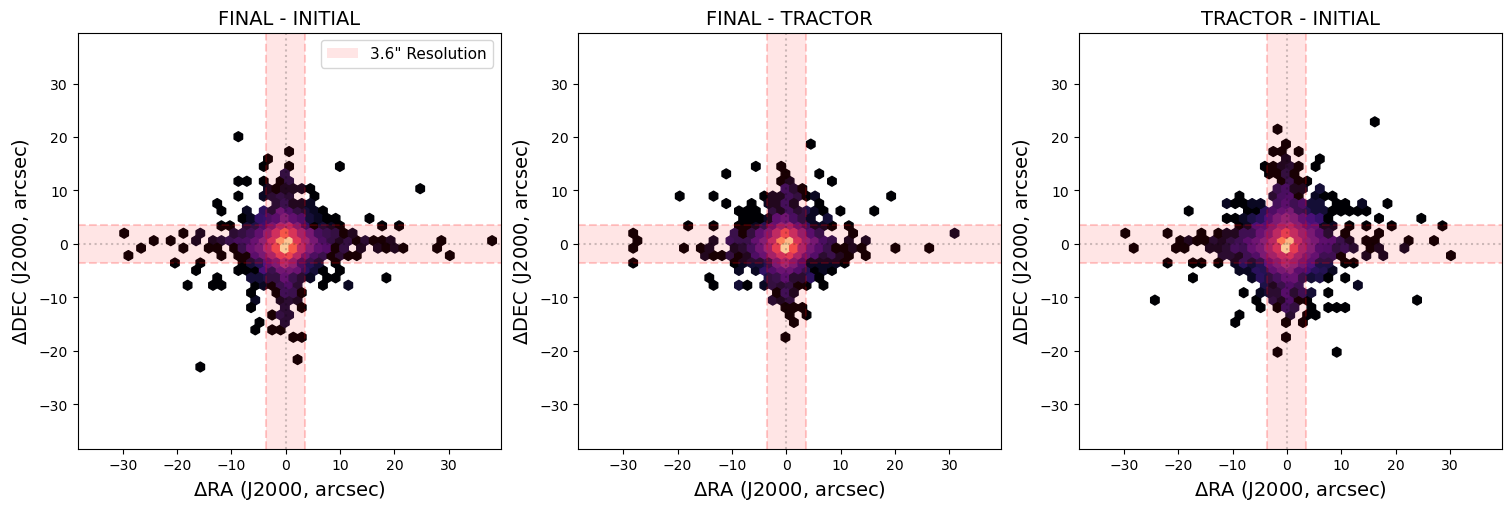

In [333]:
fig, axes = plt.subplots(1,3,figsize=(15,5),layout='constrained')
axs = axes.ravel()

columns = df_arcsec.columns

xmin=-38.3
xmax=39.52

axs[0].hexbin(df_arcsec[columns[0]], df_arcsec[columns[1]], mincnt=1,
                      gridsize=50, reduce_C_function=np.median, bins='log',
                      extent=(xmin, xmax, xmin, xmax), cmap='magma')

axs[1].hexbin(df_arcsec[columns[2]], df_arcsec[columns[3]], mincnt=1,
                      gridsize=50, reduce_C_function=np.median, bins='log',
                      extent=(xmin, xmax, xmin, xmax), cmap='magma')

axs[2].hexbin(df_arcsec[columns[4]], df_arcsec[columns[5]], mincnt=1,
                      gridsize=50, reduce_C_function=np.median, bins='log',
                      extent=(xmin, xmax, xmin, xmax), cmap='magma')

for ax in axs:

    ax.axhline(0,color='black', ls=':', alpha=0.2)
    ax.axvline(0,color='black', ls=':', alpha=0.2)

    lb_y = ax.axhline(-3.6, color='r', ls='--', alpha=0.2)
    lb_x = ax.axvline(-3.6, color='r', ls='--', alpha=0.2)
    up_y = ax.axhline(3.6, color='r', ls='--', alpha=0.2)
    up_x = ax.axvline(3.6, color='r', ls='--', alpha=0.2)

    ax.axhspan(ymin=-3.6, ymax=3.6, facecolor='red', alpha=0.1, label='3.6" Resolution')
    ax.axvspan(xmin=-3.6, xmax=3.6, facecolor='red', alpha=0.1)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(xmin, xmax)

    ax.set_xlabel(r'$\Delta$RA (J2000, arcsec)',fontsize=14)
    ax.set_ylabel(r'$\Delta$DEC (J2000, arcsec)',fontsize=14)

axs[0].legend(fontsize=11)

axs[0].set_title('FINAL - INITIAL',fontsize=14)
axs[1].set_title('FINAL - TRACTOR',fontsize=14)
axs[2].set_title('TRACTOR - INITIAL',fontsize=14)

plt.show()

#### Outliers

In [357]:
#flag large coordinate shifts -- greater than 3.6"
coord_failures = np.zeros(len(ellipse_tab), dtype=bool)

for column in df.columns:
    sep_flag=(df_arcsec[column]>3.6)  #3.6 arcsec
    coord_failures[zero_flag] += sep_flag   #because dtype is bool, any number >0 will be True
                                            #and I just want this column to be True if ANY of
                                            #the coordinate shifts are >3.6" (resolution of SGANAME)
    if np.sum(sep_flag)>0:
        sganame=ellipse_tab['SGAID'][zero_flag]
        sganame1=sganame[sep_flag]
        print(f'# Galaxies with separation > 3.6" for {column}: {len(sganame1)}')

# Galaxies with separation > 3.6" for $\Delta$RA [INIT-FINAL]: 321

# Galaxies with separation > 3.6" for $\Delta$DEC [INIT-FINAL]: 258

# Galaxies with separation > 3.6" for $\Delta$RA [FINAL-TRACTOR]: 234

# Galaxies with separation > 3.6" for $\Delta$DEC [FINAL-TRACTOR]: 181

# Galaxies with separation > 3.6" for $\Delta$RA [TRACTOR-INITIAL]: 445

# Galaxies with separation > 3.6" for $\Delta$DEC [TRACTOR-INITIAL]: 563

In [358]:
#add the column to the failure modes table
failure_modes['RA_DEC_FAILURE'] = coord_failures

### QA Two
#### Separations between BAPA [SGA2025] and BAPA [SGA2020]
 - Check for systematic offsets

In [158]:
#ellipses are only unique up to 180 degrees...0<PA<180

ba_sga2020, pa_sga2020 = sga2025_sga2020_tab['sga2020_BA_MOMENT'], sga2025_sga2020_tab['sga2020_PA_MOMENT']
ba_sga2025, pa_sga2025 = sga2025_sga2020_tab['BA_MOMENT'], sga2025_sga2020_tab['PA_MOMENT']

diff_ba = ba_sga2025-ba_sga2020
relative_diff_ba = diff_ba/ba_sga2020

#for PA, compare cos(2*difference)
#if they are nearly 90 degrees separated, then |np.cos(2*difference)| will be ~1
diff_pa = np.cos(2*(pa_sga2025-pa_sga2020))

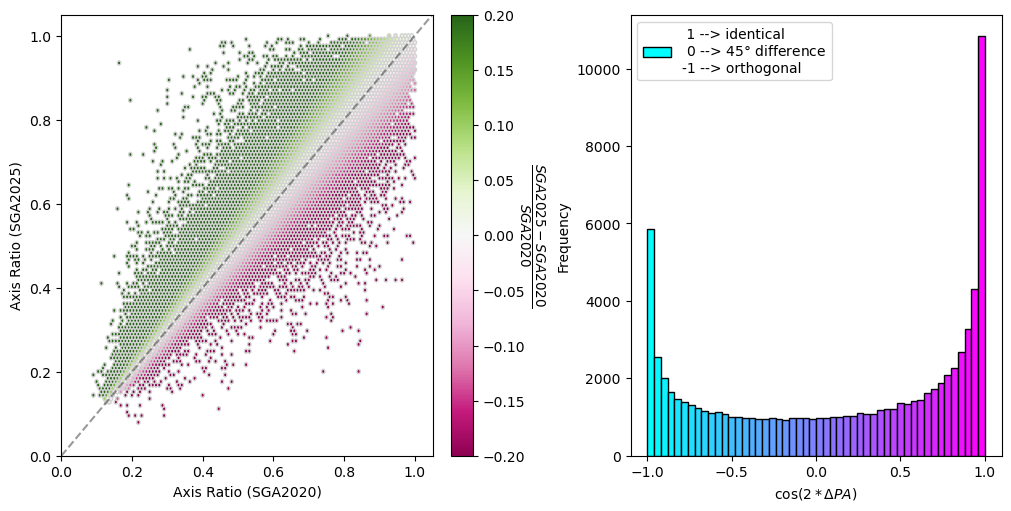

In [213]:
###
#AXIS RATIO
###
fig, axes = plt.subplots(1,2, figsize=(10, 5), layout='constrained')
#gs = fig.add_gridspec(2, 2)
axs = axes.ravel()
'''
axs = [fig.add_subplot(gs[0, 0]),   # top-left
       fig.add_subplot(gs[0, 1]),   # top-right
       fig.add_subplot(gs[1, :])]   # bottom spanning both columns
'''
im1 = axs[0].hexbin(ba_sga2020, ba_sga2025, C=relative_diff_ba,
                    cmap='PiYG', vmin=-0.2, vmax=0.2, edgecolor='lightgray')
axs[0].axline([0,0],slope=1,color='black',ls='--',alpha=0.4)
axs[0].set_xlabel('Axis Ratio (SGA2020)')
axs[0].set_ylabel('Axis Ratio (SGA2025)')
axs[0].set_xlim(0,)
axs[0].set_ylim(0,)

cbar = fig.colorbar(im1, ax=axs[0])
cbar.set_label(r'$\frac{SGA2025-SGA2020}{SGA2020}$',fontsize=14,rotation=270,labelpad=15)

###
#POSITION ANGLE
###

#from matplotlib histogram documentation
N, bins, patches = axs[1].hist(diff_pa, bins=50,
                              edgecolor='black',
                              label=' 1 --> identical\n'
                                    f' 0 --> 45$\degree$ difference\n'
                                    '-1 --> orthogonal')

#normalize to min/max of data range
norm = colors.Normalize(vmin=-1, vmax=1)
cmap = plt.cm.cool

#get bin centers
bin_centers = 0.5 * (bins[:-1] + bins[1:])

#loop over bins, not raw data
for center, patch in zip(bin_centers, patches):
    patch.set_facecolor(cmap(norm(center)))

axs[1].set_xlabel(r'$\cos(2* \Delta PA)$')
axs[1].set_ylabel('Frequency')
axs[1].legend()

plt.show()

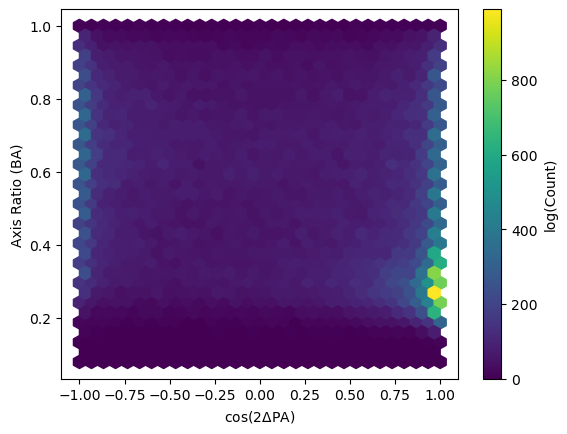

In [214]:
###
#PA vs. BA
###
fig = plt.figure()

hb = plt.hexbin(diff_pa, ba_sga2025, gridsize=30,
               cmap="viridis") #bins='log'

plt.xlabel(r'$\cos(2 \Delta \mathrm{PA})$')
plt.ylabel("Axis Ratio (BA)")

cbar = fig.colorbar(hb)
cbar.set_label("log(Count)")

plt.show()

#### Outliers
- ba_offsets: defining to be galaxies with a relative axis ratio difference of 0.4
- pa_offsets: defining to be galaxies with cos(2*diff) < 0 (between a 45 degree difference (0) or orthogonal (-1))

In [373]:
ba_offsets = np.zeros(len(failure_modes), dtype=bool)
pa_offsets = np.zeros(len(failure_modes), dtype=bool)

print(f'# galaxies with relative separation > 0.5 for BA: {len(relative_diff_ba[relative_diff_ba>0.4])}')
print(f'# galaxies with cos(2*diff) < 0 for PA: {len(diff_pa[diff_pa<0])}')
print(f'# galaxies with cos(2*diff) < -0.5 for PA: {len(diff_pa[diff_pa<0])}')
print('--------------------------------')

ba_flag = (relative_diff_ba>0.4)
pa_flag = (diff_pa<0)

#ba_flag and pa_flag only include matches in SGA2020, SGA2025 catalogs
ba_offsets[sga_flag] = ba_flag
pa_offsets[sga_flag] = pa_flag

# galaxies with relative separation > 0.5 for BA: 2258

# galaxies with cos(2*diff) < 0 for PA: 34451

# galaxies with cos(2*diff) < -0.5 for PA: 34451

--------------------------------

In [374]:
failure_modes['BA_FAILURE'] = ba_offsets
failure_modes['PA_FAILURE'] = pa_offsets

### QA Three
#### SMA_INIT vs. SMA_MOMENT
---
- To-do: color-code by sample bitmask (nearstar, instar)

In [526]:
#diam_init = ellipse_tab['DIAM_INIT'] #arcminutes

sma_init = ellipse_tab['SMA_INIT']    #arcseconds
sma_final = ellipse_tab['SMA_MOMENT'] #arcseconds

diff_sma = sma_init-sma_final

relative_diff_sma = diff_sma/sma_init

In [527]:
#finding the median ratio (slope):
scale_median = np.median(sma_final / sma_init)
print(f"Median SMA scale factor: {scale_median:.3f}")

Median SMA scale factor: 0.731

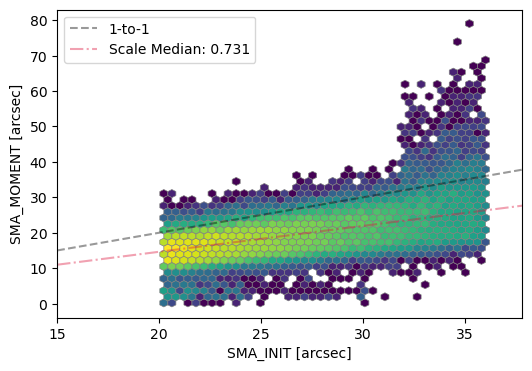

In [528]:
plt.figure(figsize=(6,4))

#mincnt=1 means ignore empty bins
hb = plt.hexbin(sma_init, sma_final, gridsize=40, cmap='viridis', mincnt=1, linewidths=0.5, edgecolors='gray',
               bins='log')

#plt.scatter(sma_init[~ba_flag], sma_final[~ba_flag], color='red', s=5)

plt.xlabel('SMA_INIT [arcsec]')
plt.ylabel('SMA_MOMENT [arcsec]')
plt.axline([0,0],slope=1,color='black',ls='--',alpha=0.4, label='1-to-1')
plt.axline([0,0], slope=scale_median, color='crimson', ls='-.',alpha=0.4,label=f'Scale Median: {scale_median:.3f}')
plt.xlim(15,)
#plt.ylim(0,92)
plt.legend(loc='upper left')
plt.show()

#### Outliers
- defined by a relative separation > 0.8

In [532]:
sma_failures = np.zeros(len(failure_modes), dtype=bool)

print(f'[red] N Galaxies with relative separation > 0.8: {len(ellipse_tab[np.abs(relative_diff_sma)>0.8])}')

sma_flag = (np.abs(relative_diff_sma)>0.8)

 N Galaxies with relative separation > 0.8: 552

In [533]:
failure_modes['SMA_FAILURE'] = sma_flag

### QA Four
#### MTOT_ERR vs. MTOT in each wavelength band
#### [COG_MTOT_G - COG_MTOT_R] vs. [COG_MTOT_R - COG_MTOT_Z]
- 10 bands --> FUV, NUV, griz, W1-4
- Notes:
    - band label inconsistency:
        - MTOT_COG_[GRIZ]
        - MTOT_COG_ERR_[GRIZ]
    - ~~All COG_MTOT_ERR_* rows are 0~~    **Fixed!**

In [37]:
bands=['FUV','NUV','G','R','I','Z','W1','W2','W3','W4']   #uppercase GRIZ for MTOT

mtots = [f'COG_MTOT_{band}' for band in bands]
mtot_errs = [f'COG_MTOT_ERR_{band}' for band in bands]

chi_2s = [f'COG_CHI2_{band}' for band in bands]
n_dofs = [f'COG_NDOF_{band}' for band in bands]

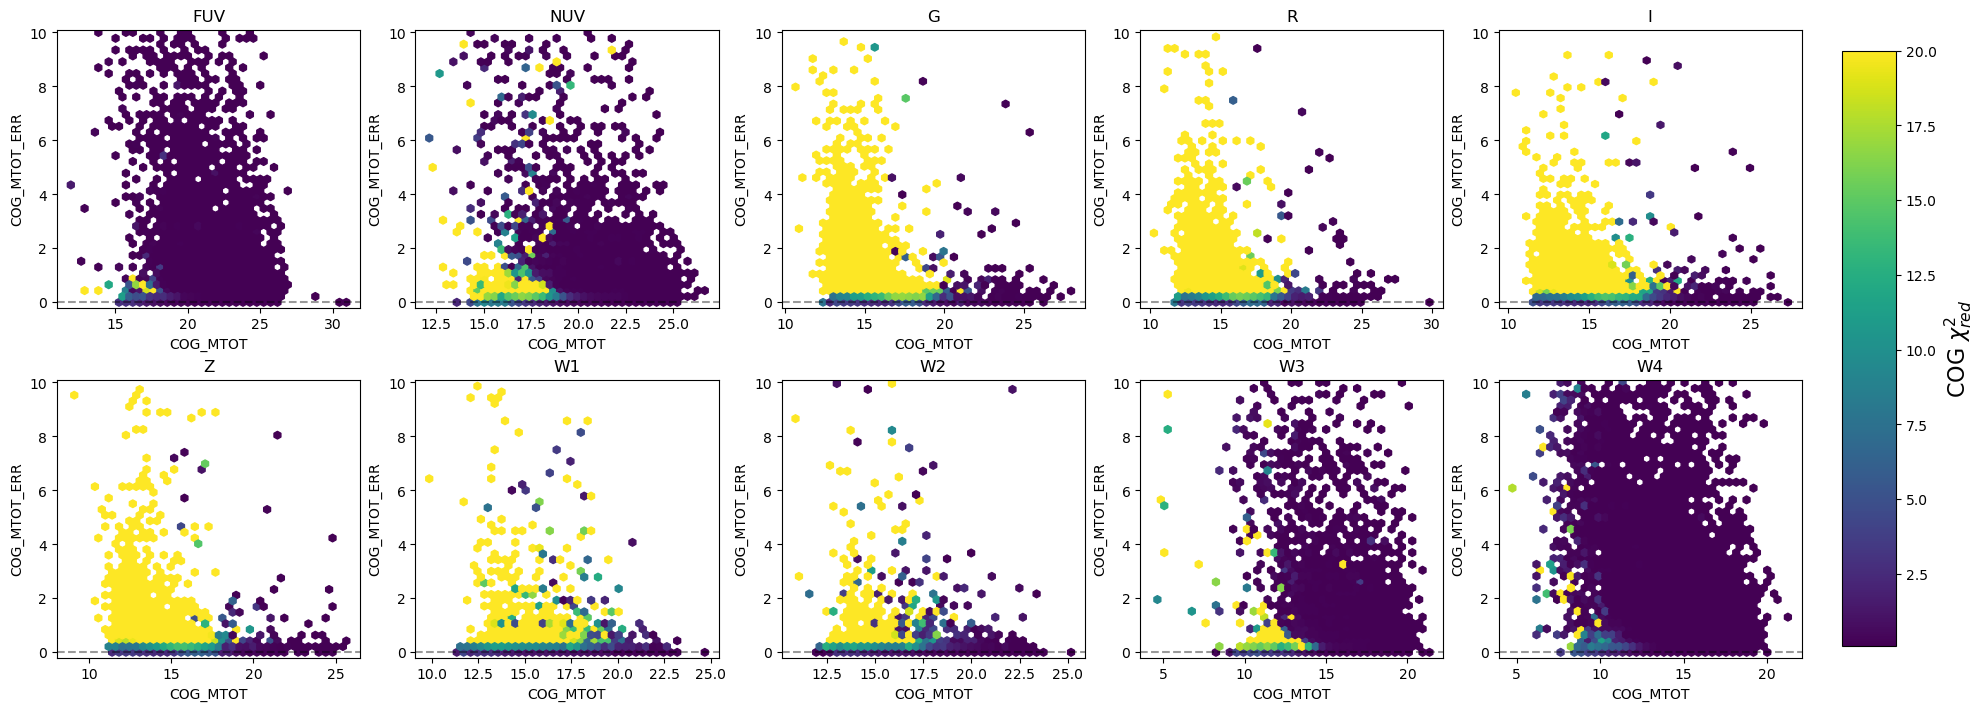

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 7), constrained_layout=True)
axes_flat = axes.ravel()

for i, ax in enumerate(axes_flat, start=1):
       
    red_chi2 = ellipse_tab[chi_2s[i-1]] / ellipse_tab[n_dofs[i-1]]

    ax.set_title(bands[i-1])
    ax.set_xlabel("COG_MTOT")
    ax.set_ylabel("COG_MTOT_ERR")
    
    err_flag = (ellipse_tab[mtot_errs[i-1]] < 10) & (ellipse_tab[mtots[i-1]] != 0)

    xdata = ellipse_tab[err_flag][mtots[i-1]]
    ydata = ellipse_tab[err_flag][mtot_errs[i-1]]
    cdata = red_chi2[err_flag]

    im1 = ax.hexbin(
        xdata, ydata, C=cdata,
        reduce_C_function=np.median,
        gridsize=40, cmap="viridis", vmin=0.1, vmax=20,
        extent=[xdata.min(), xdata.max(), ydata.min(), ydata.max()])

    ax.axhline(0, color='black', ls='--', alpha=0.4)
    ax.set_ylim(-0.2, 10.1)

cbar_ax = fig.add_axes([1.02, 0.085, 0.03, 0.85]) 
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label(r'COG $\chi^2_{red}$', fontsize=16)
cbar.solids.set(alpha=1)

plt.show()

#### Outliers
- defined by, in any band, COG_MTOT_ERR / COG_MTOT > 1

In [391]:
mtot_failures = np.zeros(len(failure_modes), dtype=bool)

for band in bands:
    large_err_flag = ((ellipse_tab[f'COG_MTOT_ERR_{band}']/ellipse_tab[f'COG_MTOT_{band}'])>1)
    mtot_failures += large_err_flag   
    if np.sum(large_err_flag)>0:
        print(f'Galaxies with fractional error > 2 in {band} band: {len(ellipse_tab[large_err_flag])}') 
        print()

Galaxies with fractional error > 2 in FUV band: 831

Galaxies with fractional error > 2 in NUV band: 275

Galaxies with fractional error > 2 in G band: 96

Galaxies with fractional error > 2 in R band: 80

Galaxies with fractional error > 2 in I band: 99

Galaxies with fractional error > 2 in Z band: 109

Galaxies with fractional error > 2 in W1 band: 142

Galaxies with fractional error > 2 in W2 band: 156

Galaxies with fractional error > 2 in W3 band: 495

Galaxies with fractional error > 2 in W4 band: 1391

In [393]:
failure_modes['MTOT_ERR_FAILURE'] = mtot_failures

#### g-r vs. r-z plot:

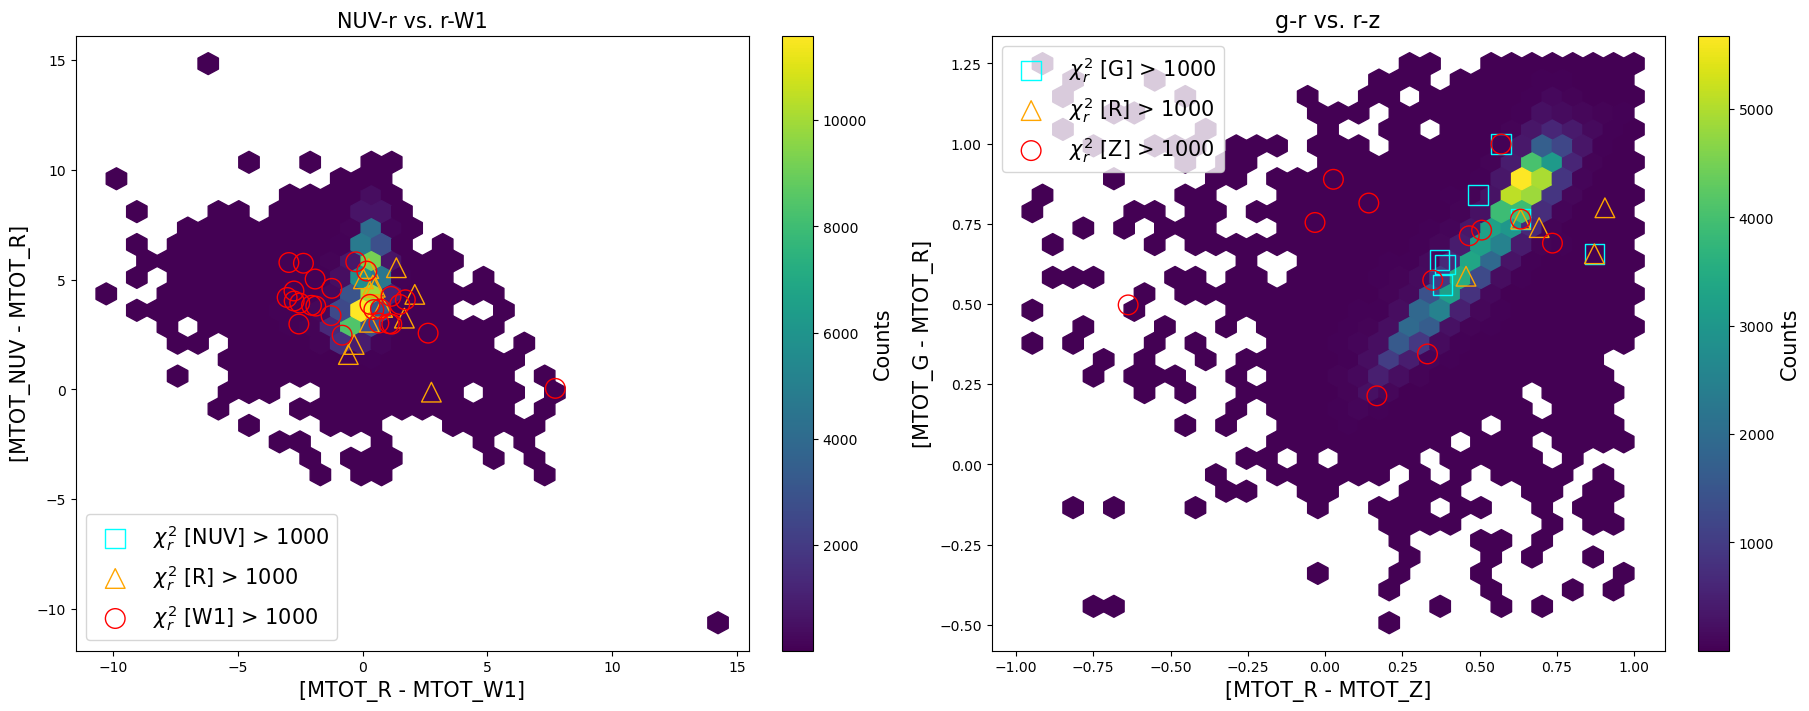

In [387]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7), constrained_layout=True)
ax1, ax2 = axes.ravel()

chi2_lim = 1000

##############################
#left panel, NUV-r vs. r-W1
##############################

#removing cases with MTOT == 0, just in case
err_flag = (ellipse_tab['COG_MTOT_W1']!=0) & \
(ellipse_tab['COG_MTOT_R']!=0) & \
(ellipse_tab['COG_MTOT_NUV']!=0)

#defining some reduced chi^2 limit for the relevant bands' COGs
red_chi2_nuv = ((ellipse_tab['COG_CHI2_NUV']/ellipse_tab['COG_NDOF_NUV']) > chi2_lim) & err_flag 
red_chi2_r = ((ellipse_tab['COG_CHI2_R']/ellipse_tab['COG_NDOF_R']) > chi2_lim) & err_flag 
red_chi2_w1 = ((ellipse_tab['COG_CHI2_W1']/ellipse_tab['COG_NDOF_W1']) > chi2_lim) & err_flag 

nuv_r = ellipse_tab['COG_MTOT_NUV'] - ellipse_tab['COG_MTOT_R'] 
r_w1 = ellipse_tab['COG_MTOT_R'] - ellipse_tab['COG_MTOT_W1']

#hexbin density map...
im1 = ax1.hexbin(r_w1[err_flag], nuv_r[err_flag], gridsize=30, cmap='viridis', mincnt=1)
cb1 = fig.colorbar(im1, ax=ax1)
cb1.set_label('Counts', fontsize=15)

ax1.scatter(r_w1[red_chi2_nuv], nuv_r[red_chi2_nuv], marker='s',
            edgecolor='cyan', facecolor='none', s=200, label=fr'$\chi^2_r$ [NUV] > {chi2_lim}')
ax1.scatter(r_w1[red_chi2_r], nuv_r[red_chi2_r], marker='^',
            edgecolor='orange', facecolor='none', s=200, label=fr'$\chi^2_r$ [R] > {chi2_lim}')
ax1.scatter(r_w1[red_chi2_w1], nuv_r[red_chi2_w1], marker='o',
            edgecolor='red', facecolor='none', s=200, label=fr'$\chi^2_r$ [W1] > {chi2_lim}')

#labels and such
ax1.set_xlabel("[MTOT_R - MTOT_W1]",fontsize=15)
ax1.set_ylabel("[MTOT_NUV - MTOT_R]",fontsize=15)

ax1.legend(fontsize=15, loc='lower left')
ax1.set_title('NUV-r vs. r-W1', fontsize=15)

##############################
##############################
##############################

#removing cases with MTOT == 0, just in case
err_flag = (ellipse_tab['COG_MTOT_G']!=0) & \
(ellipse_tab['COG_MTOT_R']!=0) & \
(ellipse_tab['COG_MTOT_Z']!=0)

#defining the colors
g_r = ellipse_tab['COG_MTOT_G'] - ellipse_tab['COG_MTOT_R'] 
r_z = ellipse_tab['COG_MTOT_R'] - ellipse_tab['COG_MTOT_Z']

#color flag (to remove significant outliers)
color_flag = (g_r > -0.5) & (g_r < 1.25) & (r_z > -1.) & (r_z < 1.)

#defining some reduced chi^2 limit for the optical bands' COGs
red_chi2_g = ((ellipse_tab['COG_CHI2_G']/ellipse_tab['COG_NDOF_G']) > chi2_lim) & err_flag & color_flag
red_chi2_r = ((ellipse_tab['COG_CHI2_R']/ellipse_tab['COG_NDOF_R']) > chi2_lim) & err_flag & color_flag
red_chi2_z = ((ellipse_tab['COG_CHI2_Z']/ellipse_tab['COG_NDOF_Z']) > chi2_lim) & err_flag & color_flag

#right panel, the 'clips'
#hexbin density map...
im2 = ax2.hexbin(r_z[color_flag & err_flag], g_r[color_flag & err_flag], gridsize=30, cmap='viridis', mincnt=1)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('Counts', fontsize=15)

#flagged points with high-ish reduced chi^2
ax2.scatter(r_z[red_chi2_g], g_r[red_chi2_g], marker='s',
            edgecolor='cyan', facecolor='none', s=200, label=fr'$\chi^2_r$ [G] > {chi2_lim}')

ax2.scatter(r_z[red_chi2_r], g_r[red_chi2_r], marker='^',
            edgecolor='orange', facecolor='none', s=200, label=fr'$\chi^2_r$ [R] > {chi2_lim}')

ax2.scatter(r_z[red_chi2_z], g_r[red_chi2_z], marker='o',
            edgecolor='red', facecolor='none', s=200, label=fr'$\chi^2_r$ [Z] > {chi2_lim}')

#labels and such
ax2.set_xlabel("[MTOT_R - MTOT_Z]",fontsize=15)
ax2.set_ylabel("[MTOT_G - MTOT_R]",fontsize=15)

ax2.legend(loc='upper left',fontsize=15)
ax2.set_title('g-r vs. r-z', fontsize=16)

plt.show()

### QA Five
#### SMA50_ vs. SMA_MOMENT
 - This diagnostic will give us an idea of how these properties correlate
   - i.e., can SMA_MOMENT/2 be a reasonable proxy for the half-light radius?
 - Note that I specifically plot 2 * SMA50_ vs. SMA_MOMENT
 - Also note that SMA50 is based on the COG model. Half-light radius.
 - Bands: NUV, GRIZ, W1
 ---
 - To-do: cut on morphology?

In [397]:
bands=['NUV','G','R','I','Z','W1']   #uppercase GRIZ for SMA50

chi_2s = [f'COG_CHI2_{band}' for band in bands]
n_dofs = [f'COG_NDOF_{band}' for band in bands]
sma50 = [f'SMA50_{band}' for band in bands]

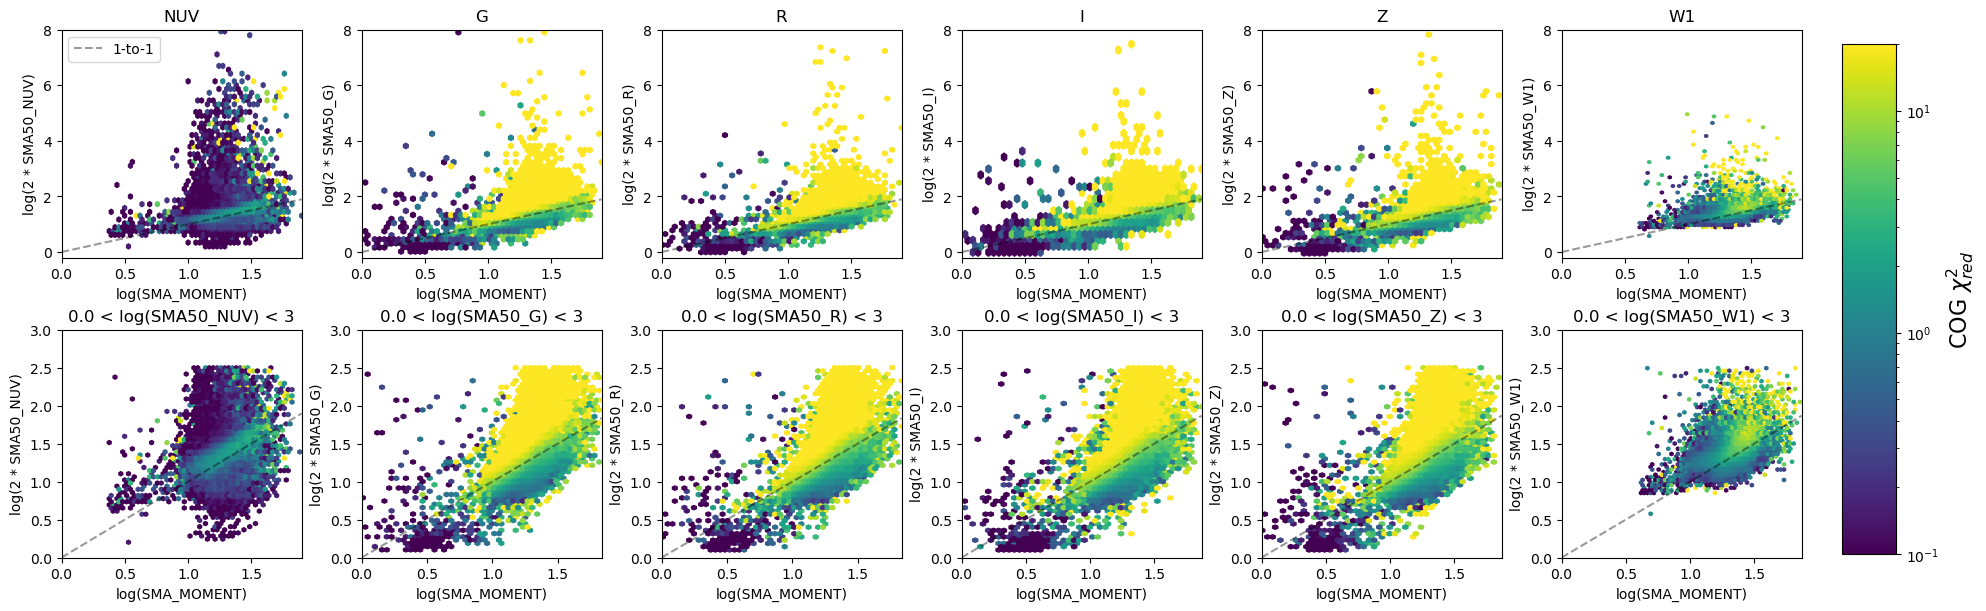

In [398]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(18, 6), constrained_layout=True)

axes_flat = axes.ravel()

for i, ax in enumerate(axes_flat, start=1):
    
    if i<7:
        index = i-1
        ylim = -0.2, 8
        title = bands[index]
        
        flag=np.ones(len(ellipse_tab), dtype=bool)
        
    else:
        index = i-7
        ylim = 0., 3
        title = f'{ylim[0]} < log(SMA50_{bands[index]}) < {ylim[1]}'
        
        flag=(np.log10(ellipse_tab[sma50[index]]*2)<2.5) & (np.log10(ellipse_tab[sma50[index]]*2)>0.1)
    
    #reduced chi-squared
    red_chi2 = ellipse_tab[chi_2s[index]][flag] / ellipse_tab[n_dofs[index]][flag]
    
    x=np.log10(ellipse_tab['SMA_MOMENT'])[flag]
    y=np.log10(ellipse_tab[sma50[index]]*2)[flag]
    
    xlim = 0, np.max(x)
    
    ax.set_title(title)
    ax.set_xlabel("log(SMA_MOMENT)")
    ax.set_ylabel(f"log(2 * SMA50_{bands[index]})")
    im = ax.hexbin(x, y, C=red_chi2,
        gridsize=50, mincnt=1,
        reduce_C_function=np.median,
        bins='log', vmin=0.1, vmax=20)
    
    ax.axline([0,0],slope=1,color='black',ls='--',alpha=0.4, label='1-to-1')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    if i==1:
        ax.legend(loc='upper left')

        
cbar_ax = fig.add_axes([1.02, 0.085, 0.03, 0.85]) 
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'COG $\chi^2_{red}$', fontsize=16)
cbar.solids.set(alpha=1)        

plt.show()

#### Outliers
- defined by relative SMA difference > 0.5

In [399]:
sma50_diffs = np.zeros(len(failure_modes), dtype=bool)

for i, band in enumerate(bands):
    diff_sma = ellipse_tab['SMA_MOMENT'] - (2*ellipse_tab[sma50[i-1]])
    relative_diff_sma = diff_sma/ellipse_tab['SMA_MOMENT']
    diff_flag = (ellipse_tab[f'COG_MTOT_ERR_{band}']>2)
    
    sma50_diffs += diff_flag  
    print(f'Galaxies with relative difference > 0.5 in {band} band: {len(ellipse_tab[diff_flag])}') 
    print()

Galaxies with relative difference > 0.5 in NUV band: 1075

Galaxies with relative difference > 0.5 in G band: 722

Galaxies with relative difference > 0.5 in R band: 450

Galaxies with relative difference > 0.5 in I band: 397

Galaxies with relative difference > 0.5 in Z band: 401

Galaxies with relative difference > 0.5 in W1 band: 273

In [400]:
failure_modes['SMA50_MOMENT_FAILURE'] = sma50_diffs

### QA Six
#### Check that SMA_AP01 is the same as SMA_MOMENT

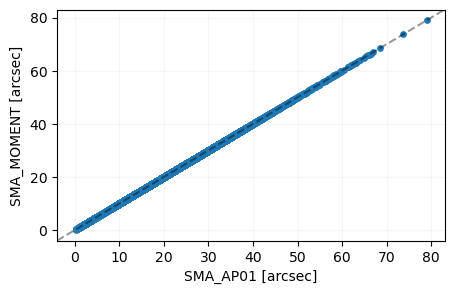

In [44]:
sma_ap1 = ellipse_tab['SMA_AP01']
sma_moment = ellipse_tab['SMA_MOMENT']

plt.figure(figsize=(5,3))
plt.scatter(sma_ap1, sma_moment,s=15)
plt.axline([0,0], slope=1, ls='--', color='black', alpha=0.4)
plt.xlabel('SMA_AP01 [arcsec]')
plt.ylabel('SMA_MOMENT [arcsec]')
plt.grid(alpha=0.1)
plt.show()

VAR check is complete. No penalty.

### QA Seven
#### MTOT vs. FLUX_AP04 fluxes (defined as the flux within an aperture SMA = 2x SMA_MOMENT)

In [45]:
bands=['FUV','NUV','G','R','I','Z','W1','W2','W3','W4']   #uppercase GRIZ for FLUX_AP04_ and COG_MTOT_

ap04s = [f'FLUX_AP04_{band}' for band in bands]
mtots = [f'COG_MTOT_{band}' for band in bands]

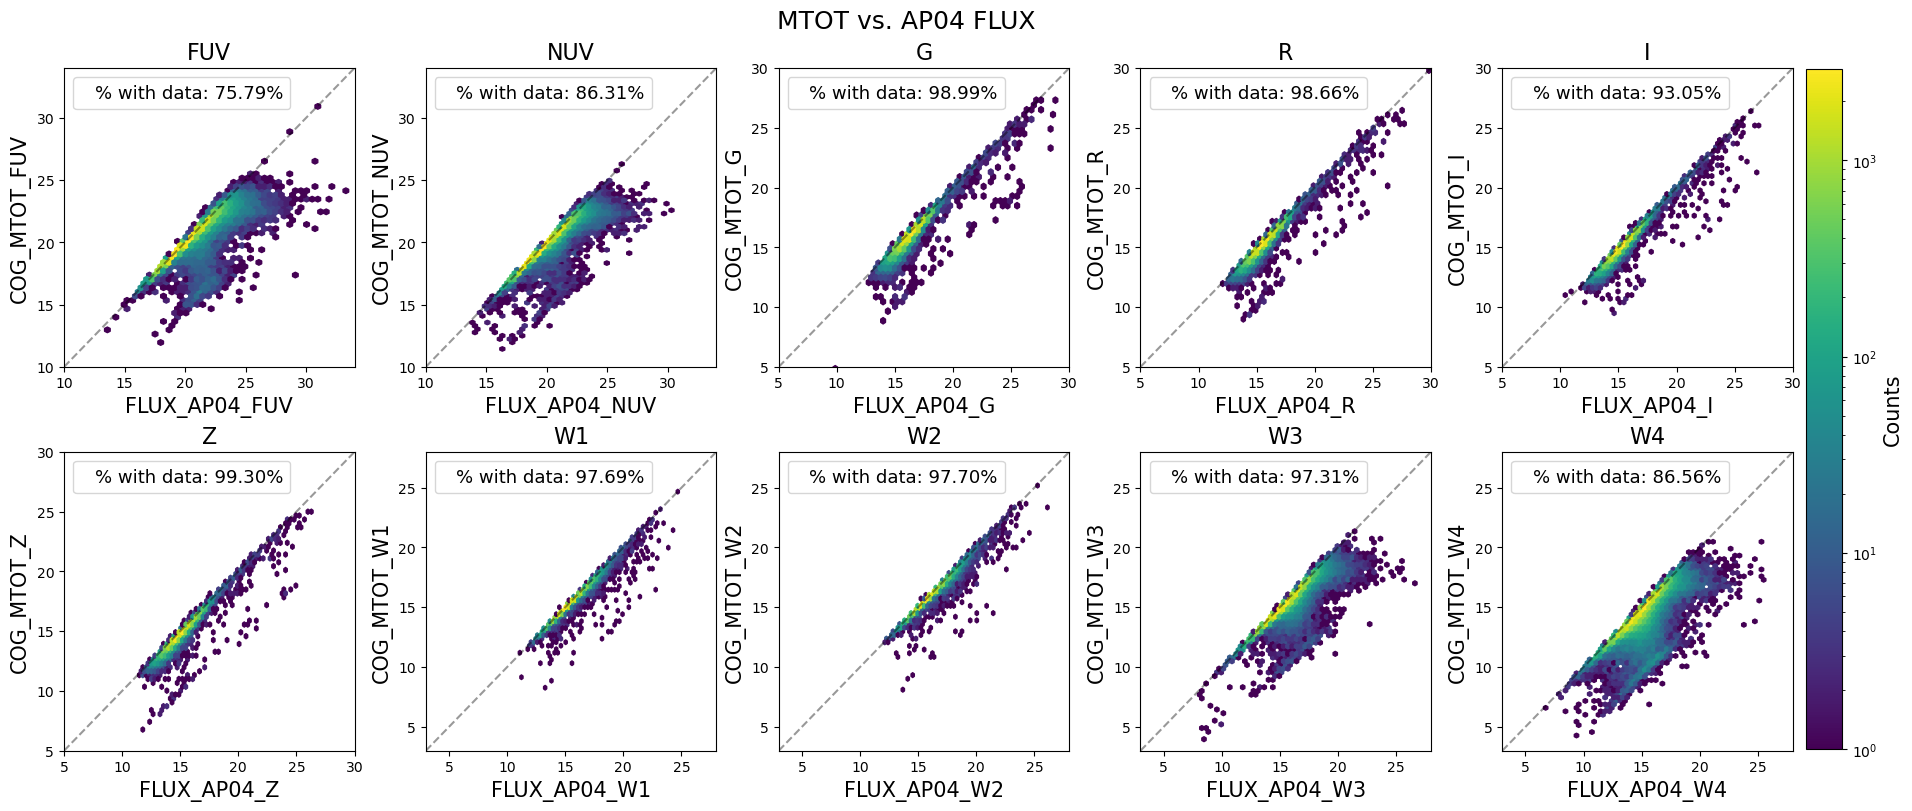

In [263]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 8), constrained_layout=True)

axes_flat = axes.ravel()

for i, ax in enumerate(axes_flat, start=1):
    ap04 = ap04s[i-1]
    mtot = mtots[i-1]
    
    err_flag = (ellipse_tab[mtot]!=0)
    
    ap04_mag = 22.5 - 2.5*np.log10(ellipse_tab[ap04])
    mtot_mag = ellipse_tab[mtot]
        
    ax.set_title(bands[i-1],fontsize=16)
    ax.set_xlabel(ap04, fontsize=15)
    ax.set_ylabel(mtot, fontsize=15)
    
    im=ax.hexbin(ap04_mag[err_flag], mtot_mag[err_flag],
        gridsize=50, mincnt=1,
        reduce_C_function=np.median,
        bins='log', label=f'% with data: {len(ap04_mag[err_flag])*100/len(ap04_mag):.2f}%')
    
    label_=''
    #if i==1:   
    #    label_='1-to-1'
    ax.axline([0,0],slope=1,color='black',alpha=0.4,ls='--',label=label_)
    
    if i<=2:
        ax.set_xlim(10,34)
        ax.set_ylim(10,34)
    
    elif i in [3,4,5,6]:
        ax.set_xlim(5,30)
        ax.set_ylim(5,30)
    
    else:       #i in [7,8,9,10]
        ax.set_xlim(3,28)
        ax.set_ylim(3,28)

    leg = ax.legend(loc='upper left', handlelength=0, fontsize=13, fancybox=True)
    leg.legendHandles[0].set_visible(False)   #set color marker to False
    
cbar_ax = fig.add_axes([1, 0.07, 0.02, 0.85]) 
cbar=fig.colorbar(im, cax=cbar_ax)
cbar.set_label(label=r'Counts', fontsize=15)

fig.suptitle(r'MTOT vs. AP04 FLUX',fontsize=18)

plt.show()

### QA Eight
#### Colors with MTOT vs. colors with all AP apertures
- Want to check whether aperture choice biases color
- NOTE: convert g-r color to magnitudes using [g-r] = -2.5*log$_{10}\Big(\frac{flux_g}{flux_r}\Big)$
     - calculating the fraction directly eliminates the need for zeropoints. :-)

In [47]:
#g-r (MTOT) vs. g-r (AP), and r-z (MTOT) vs. r-z (AP)?
#one panel per aperture -- AP00, AP01, AP02, AP03, AP04

In [401]:
apertures = ['00', '01', '02', '03', '04']

mtot_g = ellipse_tab['COG_MTOT_G']
mtot_r = ellipse_tab['COG_MTOT_R']
mtot_z = ellipse_tab['COG_MTOT_Z']

err_flag = (mtot_g!=0) & (mtot_r!=0) & (mtot_z!=0)

mtot_g_r = mtot_g[err_flag] - mtot_r[err_flag]
mtot_r_z = mtot_r[err_flag] - mtot_z[err_flag]

sganames = ellipse_tab['SGAID'][err_flag]

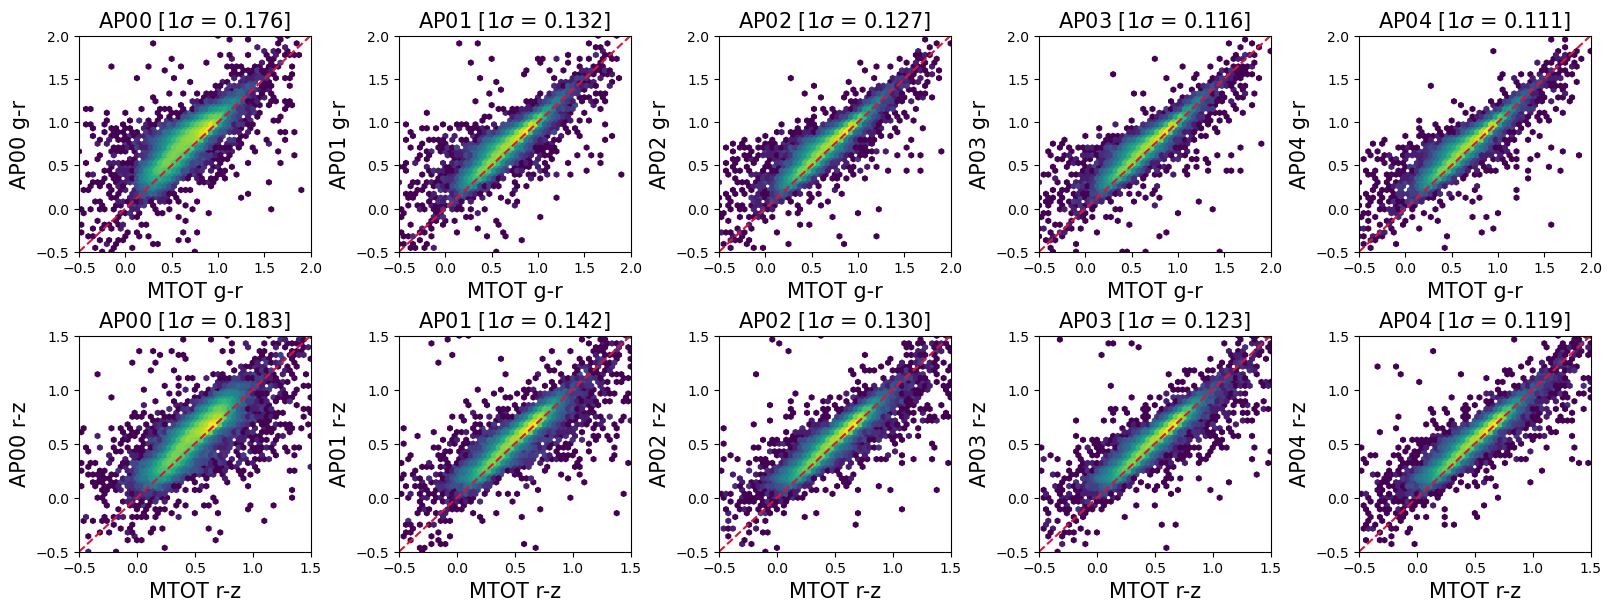

In [408]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 6), constrained_layout=True)
axes_flat = axes.ravel()

#bool array flag for galaxies with large color differences
color_diffs = np.zeros(len(failure_modes), dtype=bool)

for i, ax in enumerate(axes_flat, start=1):
    
    if i<6:
        ap_name=apertures[i-1]
    else:
        ap_name=apertures[i-6]
        
    ap_g = f'FLUX_AP{ap_name}_G'
    ap_r = f'FLUX_AP{ap_name}_R'
    ap_z = f'FLUX_AP{ap_name}_Z'
    
    g_r_ap = 2.5*-1*np.log10(ellipse_tab[ap_g]/ellipse_tab[ap_r])[err_flag]   #calculate color in magnitudes!
    r_z_ap = 2.5*-1*np.log10(ellipse_tab[ap_r]/ellipse_tab[ap_z])[err_flag]

    if i<6:
        ###############################
        ####         g-r           ####
        ###############################
        
        xmin=-0.5
        xmax=2
        
        #remove infinity values from difference
        diff = g_r_ap-mtot_g_r
        diff_clean = diff[np.isfinite(diff)]
        
        ax.set_title(f'AP{ap_name} [1$\sigma$ = {np.nanstd(diff_clean):.3f}]',fontsize=15)
        ax.set_ylabel(f'AP{ap_name} g-r', fontsize=15)
        ax.set_xlabel('MTOT g-r',fontsize=15)
        
        flag = (np.abs((mtot_g_r - g_r_ap)) > 1.0)
        
        im=ax.hexbin(mtot_g_r, g_r_ap,
        gridsize=50, mincnt=1,
        reduce_C_function=np.median,
        bins='log',extent=(xmin,xmax,xmin,xmax))
        
        ax.axline([0,0], slope=1, color='crimson', alpha=1, ls='--')
        
    else:
        ###############################
        ####         r-z           ####
        ###############################
        
        xmin=-0.5
        xmax=1.5
        
        #remove infinity values from difference
        diff = r_z_ap-mtot_r_z
        diff_clean = diff[np.isfinite(diff)]
        
        ax.set_title(f'AP{ap_name} [1$\sigma$ = {np.nanstd(diff_clean):.3f}]',fontsize=15)
        ax.set_ylabel(f'AP{ap_name} r-z',fontsize=15)
        ax.set_xlabel('MTOT r-z',fontsize=15)
        
        flag = (np.abs((mtot_r_z - r_z_ap)) > 1.0)
        
        im=ax.hexbin(mtot_r_z, r_z_ap,
        gridsize=50, mincnt=1,
        reduce_C_function=np.median,
        bins='log',extent=(xmin,xmax,xmin,xmax))
        
        ax.axline([0,0], slope=1, color='crimson', alpha=1, ls='--')
        
    #merge flag with color flag!
    if i>1:
        color_diffs[err_flag] += flag

    ax.set_ylim(xmin, xmax)
    ax.set_xlim(xmin, xmax)


plt.show()

#### Outliers
- loosely defined as AP0[int] > 1, where [int] = 1, 2, 3, 4

In [409]:
failure_modes['COLOR_FAILURE'] = color_diffs

### QA Nine
#### Plot SMA_MOMENT vs.  R[isophote]_R
 - how does SMA_MOMENT correlate with isophotal radii for r-band (R)?
 - R24, R25, R26

In [285]:
%run isophote_cornerplot.py

Use: generate_cornerplot(data_table=None, band='R')

Enter your own astropy.table object for data_table; defaults to my (the author's) path.

Band can be G, R, I, Z

<Figure size 640x480 with 0 Axes>

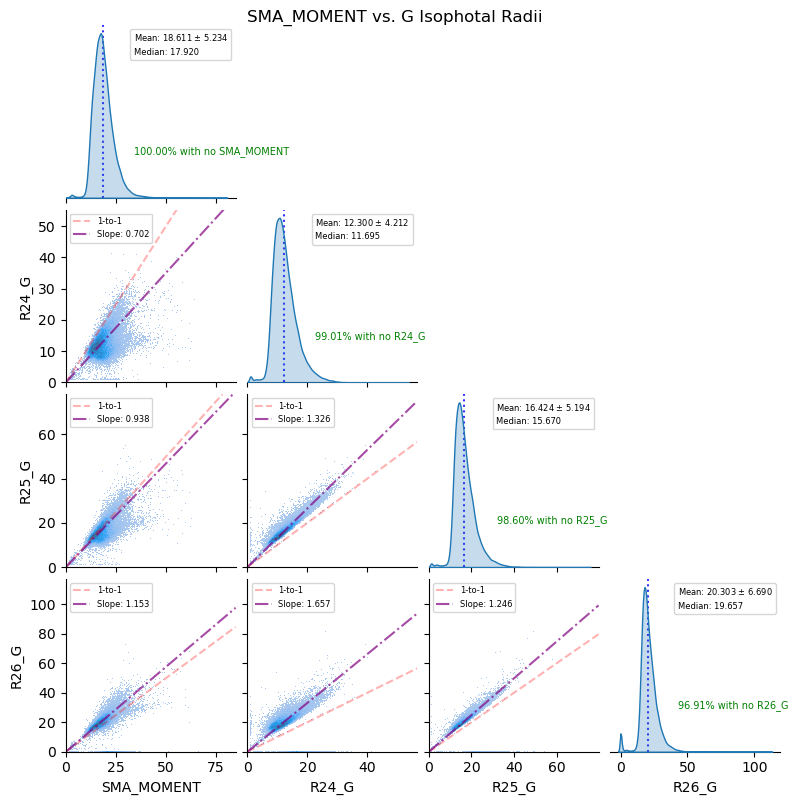

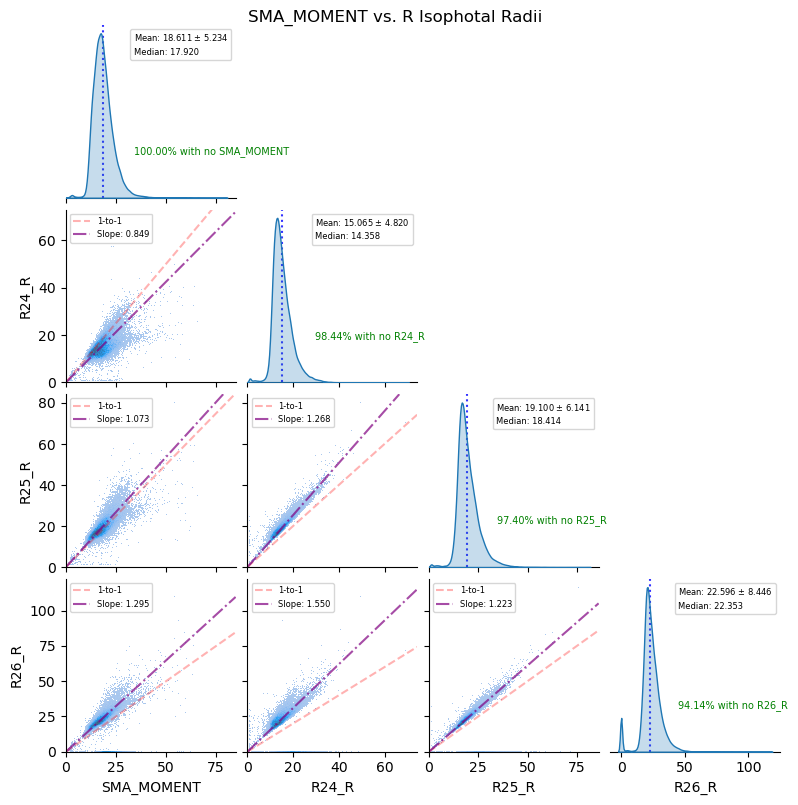

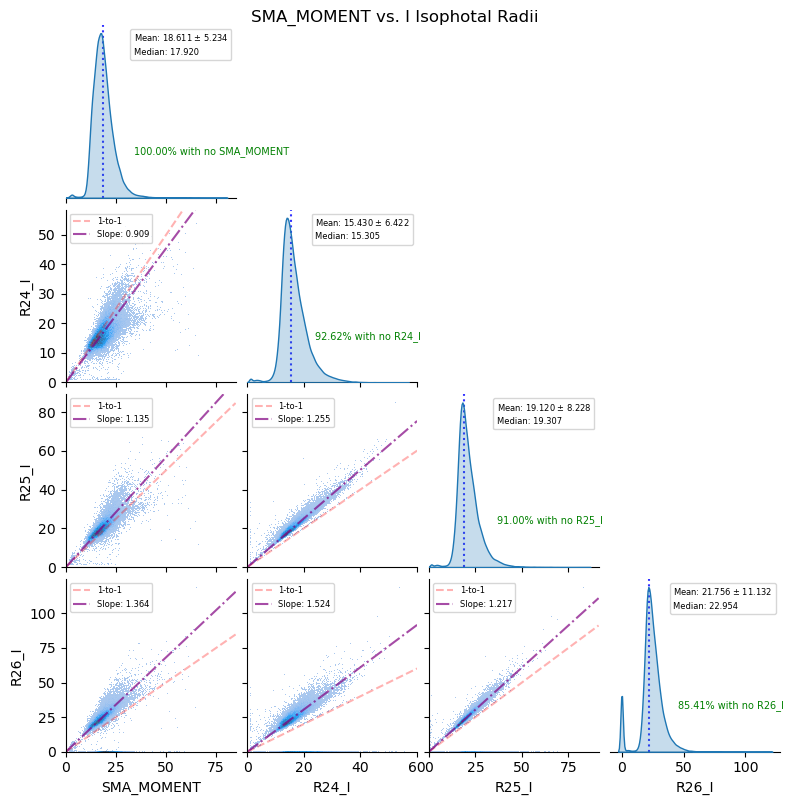

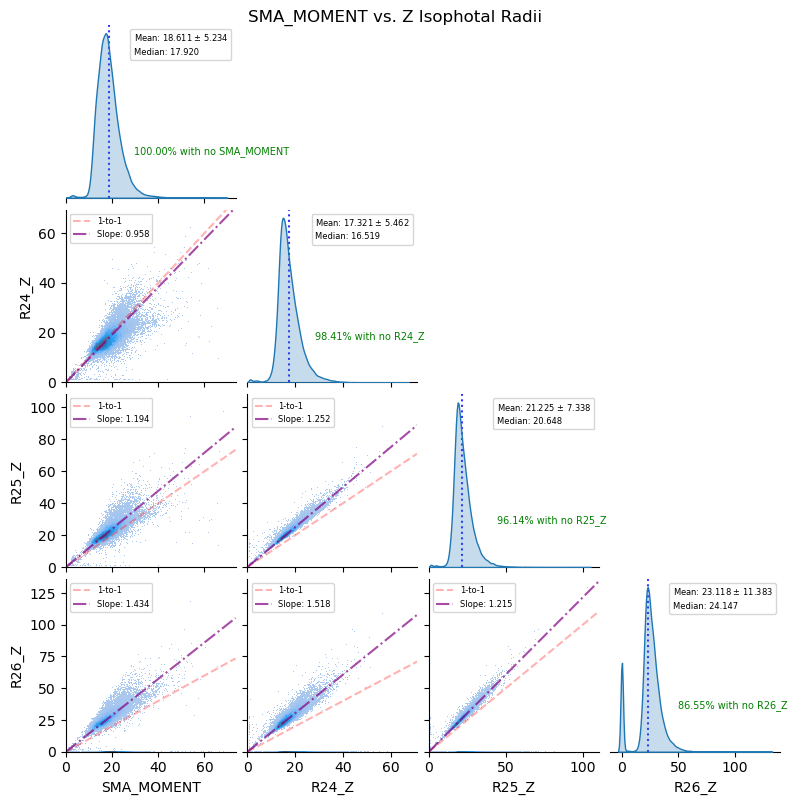

In [286]:
for band in ['G', 'R', 'I', 'Z']:
    generate_cornerplot(data_table=ellipse_tab, band=band)

### QA Ten
#### Plot R26_R [SGA2025] vs.  R26_R [SGA2020]
 - Want to ensure the adopted diameters for DR11 match the SGA-2020 D26 values in the mean
     - that is, check that the radii are not systematically offset

In [413]:
#remove instances where there is no data -- R26_R for SGA2020 or SGA2025 = 0
zero_flag = (sga2025_sga2020_tab['R26_R']>0) & (sga2025_sga2020_tab['sga2020_R26_R']>0)

In [414]:
r26_2020 = sga2025_sga2020_tab['sga2020_R26_R'][zero_flag]
r26_2025 = sga2025_sga2020_tab['R26_R'][zero_flag]

print('Matches:', len(r26_2020))

Matches: 81474

In [415]:
#difference
r26_ratio = r26_2025 / r26_2020
mean_ratio = np.mean(r26_ratio)
median_ratio = np.median(r26_ratio)
stdev_ratio = np.std(r26_ratio)

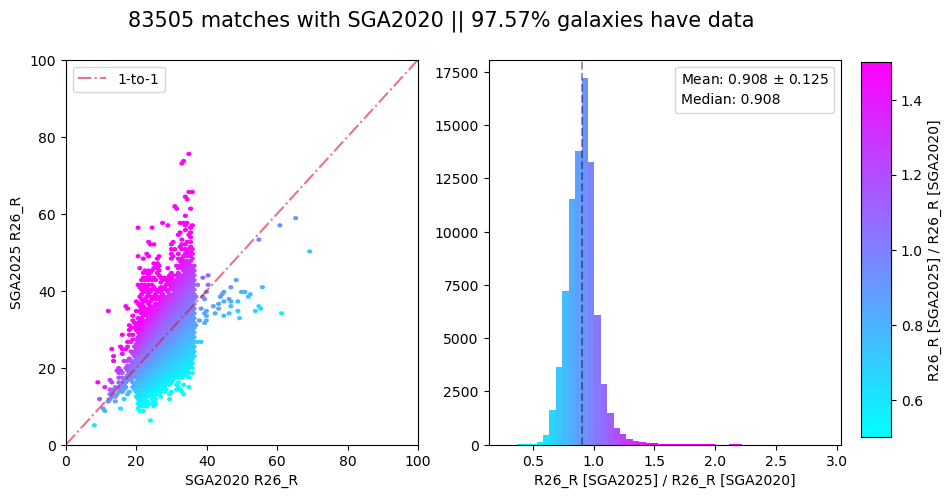

In [424]:
#plot for diagnostic purposes. which SG coordinate best correlates with redshift?
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

im1 = axs[0].hexbin(r26_2020, r26_2025, C=r26_ratio,
                    cmap='cool', vmin=0.5, vmax=1.5)#, edgecolor='lightgray')
axs[0].axline([0,0],slope=1,color='crimson',ls='-.',alpha=0.6,label='1-to-1')
axs[0].set_xlabel('SGA2020 R26_R')
axs[0].set_ylabel('SGA2025 R26_R')
axs[0].set_xlim(0,100)
axs[0].set_ylim(0,100)

axs[0].legend()

axs[1].axvline(mean_ratio,color='black',ls='--',alpha=0.4,
                   label=f'Mean: {mean_ratio:.3f} $\pm$ {stdev_ratio:.3f}')

axs[1].axvline(median_ratio,alpha=0,label=f'Median: {median_ratio:.3f}')

axs[1].set_xlabel(f'R26_R [SGA2025] / R26_R [SGA2020]')
axs[1].legend(handlelength=0, handletextpad=0)   #the args remove the marker from the legend

###
#from matplotlib histogram documentation
###
N, bins, patches = axs[1].hist(r26_ratio, bins=50)

#normalize to min/max of data range
norm = colors.Normalize(vmin=0.5, vmax=1.5)
cmap = plt.cm.cool

#get bin centers
bin_centers = 0.5 * (bins[:-1] + bins[1:])

#loop over bins, not raw data
for center, patch in zip(bin_centers, patches):
    patch.set_facecolor(cmap(norm(center)))
    
cbar_ax = fig.add_axes([0.92, 0.125, 0.03, 0.75]) 
cbar=fig.colorbar(im1, cax=cbar_ax)
cbar.set_label(f'R26_R [SGA2025] / R26_R [SGA2020]')
 
fig.suptitle(f'{len(sga2025_sga2020_tab)} matches with SGA2020 ||'
            f' {(len(sga2025_sga2020_tab[zero_flag])*100/(len(sga2025_sga2020_tab))):.2f}% galaxies have data',
            fontsize=15)    

plt.show()

#### Outliers
- defined by [0.42 < r26_r ratio < 2.2], where r26_r_ratio = R26_R [SGA2025] / R26_R [SGA2020]

In [435]:
r26_r_diffs = np.zeros(len(failure_modes), dtype=bool)

r26_2020 = sga2025_sga2020_tab['sga2020_R26_R']
r26_2025 = sga2025_sga2020_tab['R26_R']

r26_ratio_all = r26_2025 / r26_2020

#don't accidentally flag galaxies with zero R26_R (SGA2020 and/or SGA2025)
r26_r_flag = ((np.abs(r26_ratio_all)>2.2) | (np.abs(r26_ratio_all)<0.42)) & (zero_flag)

#any galaxies not in SGA2020 are given False; the rest are given the r26_r_flag
r26_r_diffs[sga_flag] = r26_r_flag

In [436]:
failure_modes['R26_R_FAILURE'] = r26_r_diffs

### Finalizing the Error-Handling Table

In [560]:
#create one more column -- True is ANY of the bool columns are True; False if NONE of the columns are True
any_failure_flag = np.zeros(len(failure_modes),dtype=bool)

In [561]:
#reset failure_modes['ANY_FAILURE'], if needed
#otherwise...if there is a True in the column that no longer applies, any(row_bools) will output True
failure_modes['ANY_FAILURE'] = any_failure_flag   #any_failure_flag is an array of False's. 

In [562]:
cols = failure_modes.columns[1:]  #skips SGAID column

#takes all table arrays and stacks them column-wise. I need a proper numpy array so that
#I can use np.any to faciliate the detection of True and False entries in each column per row
bool_data = np.column_stack([failure_modes[c].data for c in cols])
any_failure_flag = np.any(bool_data, axis=1)

In [563]:
failure_modes['ANY_FAILURE'] = any_failure_flag